# 0. Autoencoder and Variational Autoencoder feature extraction for Regression in Equilibrium Astrochemistry 

In this notebook, we attempt to build an autoencoder and a regression model to extract important features from chemical abundances and use encodered features to predict gas temeperature and chemical abundances times serieses.

Since most gas cooling in astrophysical contexts comes from molecules radiating energy away, their abundances essentially set the cooling rate. Since the temperature affects how the gas evolves dynamically, any physics simulation of processes such as star formation requires a method of accurately calculating the chemistry of the gas.

Unfortunately, accurately calculating the temperature and chemistry (henceforth thermochemistry) of a gas can be computationally expensive. Many approaches such as simplifying chemical networks to only the most important species and reactions or assuming equilibrium are used to decrease the cost of these calculations. However, even these can fail for large simulations where an object is broken up into many parts which all require a thermochemical calculation.

The aim of this work is to use Autoencoders and Variational autoencoders for feature extraction and then to solve the chemistry and gas temperature with sufficient accuracy and speed to render a host of new problems attainable. 

In [1]:
# tensorflow
from tensorflow.keras.layers import Input, Dense, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns
from glob import glob
from tqdm import tqdm

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)


Using TensorFlow v2.8.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. **Even you are not using Google Colab, please make sure you run these two cells.** 

To access the data from Google Colab, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data/'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    with open('../local_data_path.txt', 'r') as f: data_path = f.read().splitlines()[0]

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

OK
75 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 75 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...
2022/03/04 13:52:30.102722 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/sciml-workshop-data
2022/03/04 13:52:30.132068 Opening GCS connection...
2022/03/04 13:52:30.394008 Mounting file system "sciml-workshop"...
2022/03/04 13:52:30.456638 File system has been successfully mounted.


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  68567      0 --:--:-- --:--:-- --:--:-- 68567




Updated property [core/project].


---

# 1. Load the dataset

### Read raw data

We start by loading the dataset taken from [Chemulator - Holdship et al. 2020](https://ui.adsabs.harvard.edu/abs/2021A%26A...653A..76H/abstract).

The full **Chemulator** dataset contains the abundances and physical parameters as a function of time when exposed to different conditions. The physical parameters are:
- Gas temperature 
- Gas density
- Radation Field 
- Local cosmic ray ionization rate 
- Ratio of the abundance of metals in this gas to the sollar abundance of metal 
- Total Column density
- $H_2$ Column density
- $C$ Column density

and the abundances are:

'H','H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+', 'C+', 'C', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+', 'CH4', 'O', 'CH5+', 'OH+', 'OH', 'H2O+', 'H2O', 'H3O+', 'MG', 'MG+', 'CO+', 'CO', 'HCO+', 'O2', 'O2+','E-'

The data are stored in the hdf file 'NHS/small_chemulator_dataset_train.hdf' and 'NHS/small_chemulator_dataset_test.hdf'.


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
train_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_train.hdf'), 'df')  
test_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_test.hdf'), 'df')  
```
    
</p>
</details>


In [4]:
train_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_train.hdf'), 'df')  
test_data = pd.read_hdf(join(data_path, 'NHS/small_chemulator_dataset_test.hdf'), 'df')  

In [5]:
class Scale_info:
    def __init__(self, data):
        self.min = np.min(data, axis = 0)
        self.max = np.max(data, axis = 0)

def preprocessing(df, data_type = 'chemical'):
    arr = df.copy()
    arr = np.log10(arr)
    if data_type == 'chemical':
        arr=np.where(arr<-20,-20,arr)
    arr = arr.astype(np.float32)
    reliable_min = np.percentile(arr, 2, axis =0)
    reliable_max = np.percentile(arr, 98, axis =0)

    arr = (arr - reliable_min)/(reliable_max - reliable_min)
    arr = np.clip(arr, 0., 1.)
    
    return arr # array

abundances = ['H','H+', 'H2', 'H2+', 'H3+', 'HE', 'HE+', 'C+', 'C', 'CH', 'CH+', 'CH2',
       'CH2+', 'CH3+', 'CH3', 'CH4+', 'O+', 'CH4', 'O', 'CH5+', 'OH+', 'OH',
       'H2O+', 'H2O', 'H3O+', 'MG', 'MG+', 'CO+', 'CO', 'HCO+', 'O2', 'O2+','E-']


### Preprocessing chemical abundances
train_data['HE'] = 0.1*train_data['metallicity']
chemical_abundances = train_data[abundances]
chemical_abundances = preprocessing(chemical_abundances, data_type = 'chemical')
train_data[abundances] = chemical_abundances

test_data['HE'] = 0.1*test_data['metallicity']
chemical_abundances_test = test_data[abundances]
chemical_abundances_test = preprocessing(chemical_abundances_test, data_type = 'chemical')
test_data[abundances] = chemical_abundances_test


### Preprocessing physical parameters
physics_labels=['gas_temp','gas_density','radfield','zeta','coldens','h2col','ccol',"metallicity"]
train_data[physics_labels] = preprocessing(train_data[physics_labels], data_type = 'physical')
test_data[physics_labels] = preprocessing(test_data[physics_labels], data_type = 'physical')

In [6]:
train_all = np.array(train_data[physics_labels + abundances])[:-1]
train_all_target = np.array(train_data[['gas_temp']+abundances])[1:]
test_all = np.array(test_data[physics_labels + abundances])[:-1]
test_all_target = np.array(test_data[['gas_temp']+abundances])[1:]

print(train_all.shape)
print(train_all_target.shape)
print(test_all.shape)
print(test_all_target.shape)

(1999999, 41)
(1999999, 34)
(399999, 41)
(399999, 34)


---

# 2. Build the network

### Regression using all abundances


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model_all = Sequential()
model_all.add(Input(shape=(train_all.shape[1],)))

for layer in [256, 256]:
    model_all.add(Dense(layer, activation="relu"))

model_all.add(Dense(1+len(abundances),activation='sigmoid'))        

model_all.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_all.fit(train_all, train_all_target, epochs=5, batch_size=128, 
                             validation_data = (test_all, test_all_target) ,callbacks=[stopper])
```
    
</p>
</details>

In [7]:
model_all = Sequential()
model_all.add(Input(shape=(train_all.shape[1],)))

for layer in [256, 256]:
    model_all.add(Dense(layer, activation="relu"))

model_all.add(Dense(1+len(abundances),activation='sigmoid'))        

model_all.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping( monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_all.fit(train_all, train_all_target, epochs=5, batch_size=128, 
                             validation_data = (test_all, test_all_target) ,callbacks=[stopper])

Epoch 1/5
15625/15625 [==============================] - 97s 6ms/step - loss: 6.2628e-04 - val_loss: 5.1173e-04
Epoch 2/5
15625/15625 [==============================] - 73s 5ms/step - loss: 3.0776e-04 - val_loss: 5.0747e-04
Epoch 3/5
15625/15625 [==============================] - 75s 5ms/step - loss: 2.7906e-04 - val_loss: 4.9190e-04
Epoch 4/5
15625/15625 [==============================] - 72s 5ms/step - loss: 2.6434e-04 - val_loss: 4.2054e-04
Epoch 5/5
15625/15625 [==============================] - 73s 5ms/step - loss: 2.5439e-04 - val_loss: 4.1630e-04


---

# 3. Analyse results

### Take a look at some results

Using predict_multiple_timesteps function we can predict abundances and gas temperature time series from their initial valeus.

In [8]:
def predict_multiple_timesteps(model, init_condition, time = 999):
    x = init_condition.copy()
    predictions = [x.copy()]
    for i in tqdm(range(time)):
        pred = model.predict(x)
        x[:, 0] = pred[:, 0]
        x[:, len(physics_labels):] = pred[:, 1:]
        predictions.append(x.copy())
    return predictions

### Predict multiple timesteps

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
init_idx = 0
init_condition = train_all[init_idx:init_idx+1]
pred_all = predict_multiple_timesteps(model_all, init_condition, time = 999)

pred_all = np.stack(pred_all).reshape(1000, train_all.shape[1])
```
    
</p>
</details>

In [ ]:
init_idx = 0
init_condition = train_all[init_idx:init_idx+1]
pred_all = predict_multiple_timesteps(model_all, init_condition, time = 999)

pred_all = np.stack(pred_all).reshape(1000, train_all.shape[1])

100%|██████████| 999/999 [01:04<00:00, 15.55it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are re

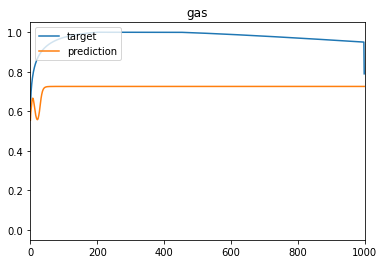

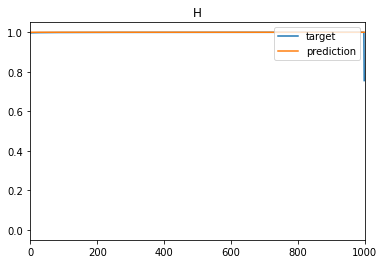

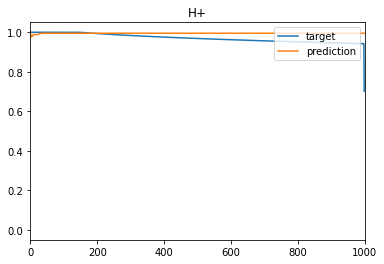

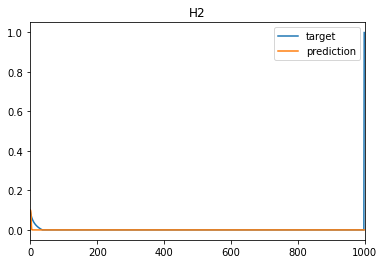

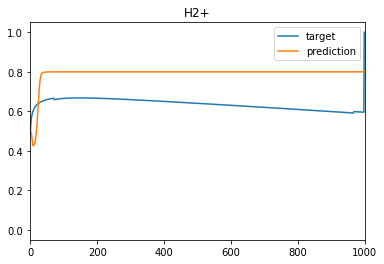

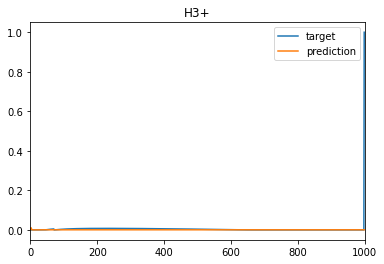

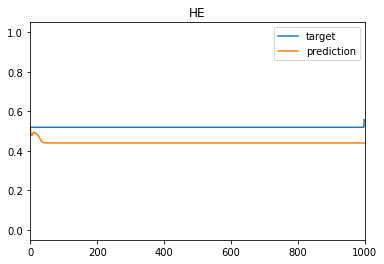

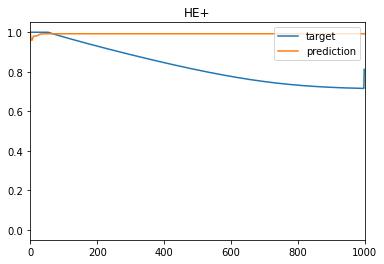

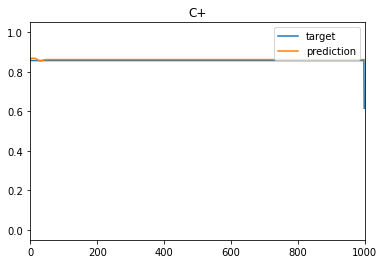

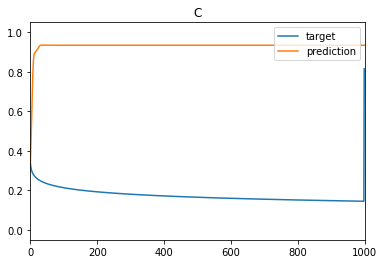

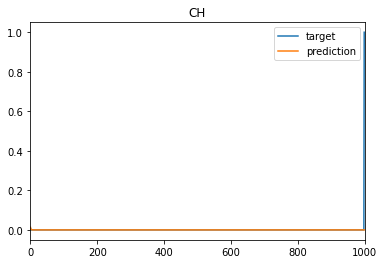

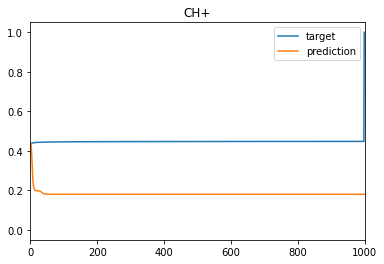

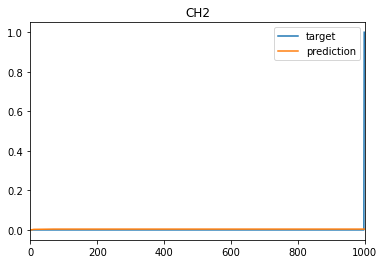

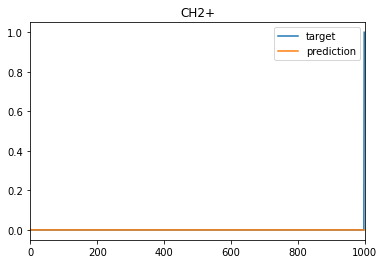

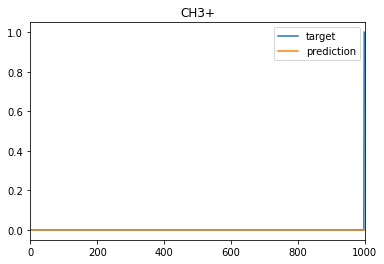

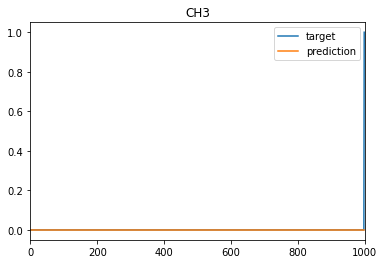

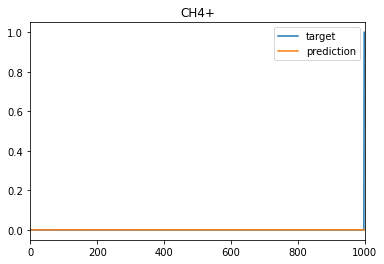

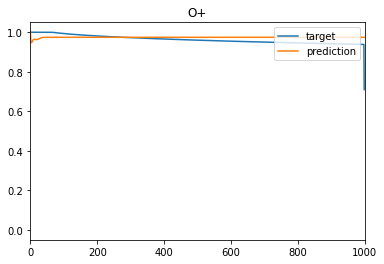

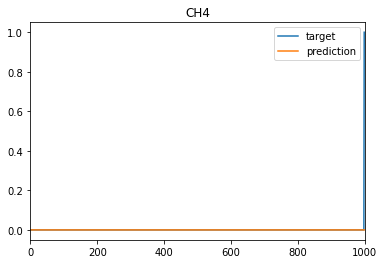

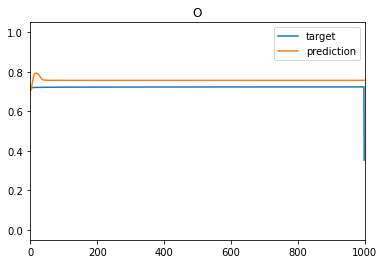

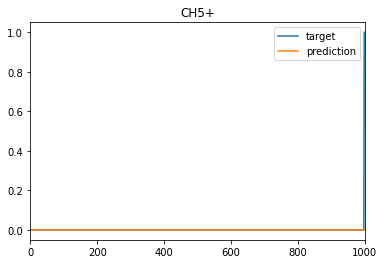

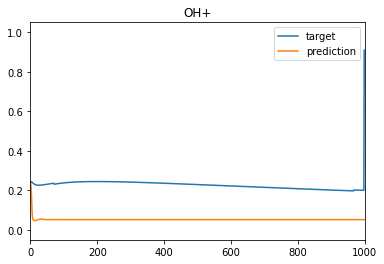

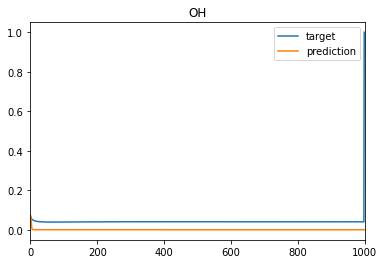

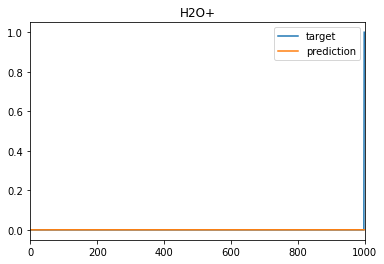

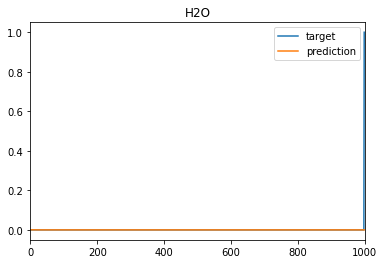

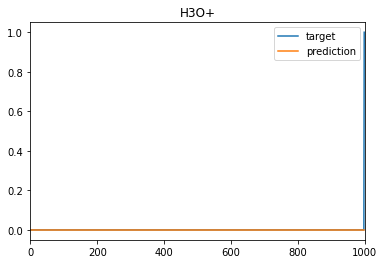

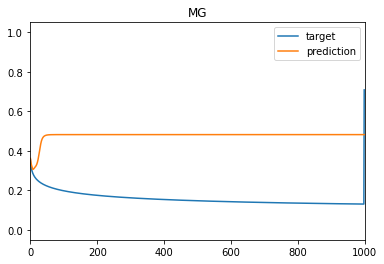

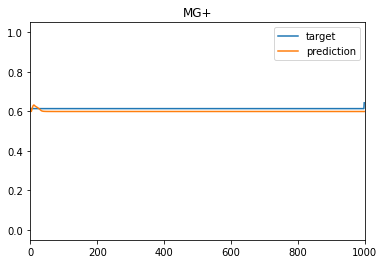

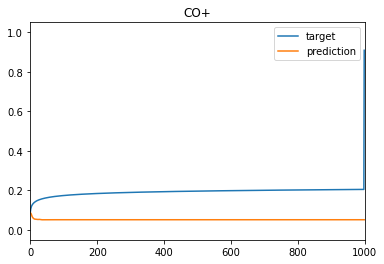

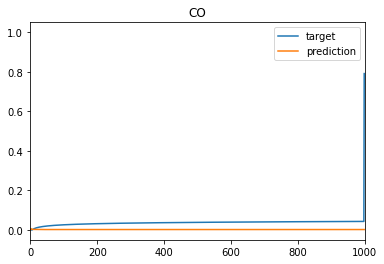

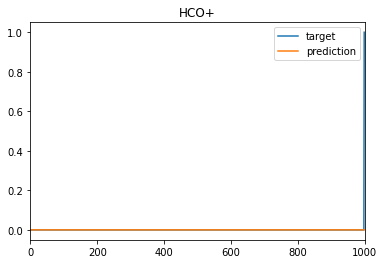

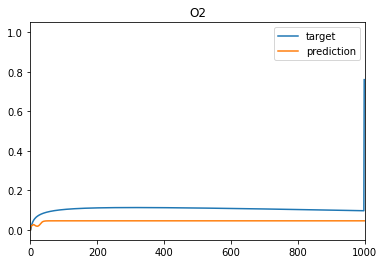

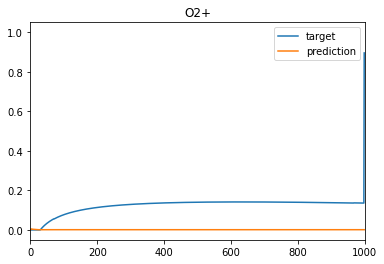

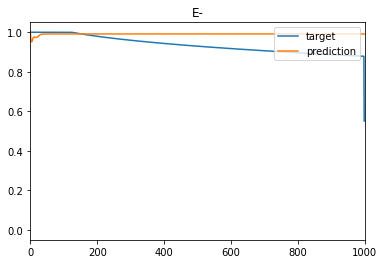

In [14]:
plt.figure()
plt.plot(train_all_target[init_idx:init_idx+1000, 0], label = 'target')
plt.plot(pred_all[:, 0], label = 'prediction')
plt.axis([-1., 1001., -0.05, 1.05])
plt.title('gas')
plt.legend(loc = 1)
for i in range(len(abundances)):
    plt.figure()
    plt.plot(train_all_target[init_idx:init_idx+1000, 1+i], label = 'target')
    plt.plot(pred_all[:, len(physics_labels)+i], label = 'prediction')
    plt.axis([-1., 1001., -0.05, 1.05])
    plt.title(abundances[i])
    plt.legend(loc = 1)

# 4. Regression using features extracted by Autoencoders

In [15]:
train_abundances = np.array(train_data[abundances])
test_abundances = np.array(test_data[abundances])

### Build AE with 8 dimensional latent space

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
encoding_dim = 8  

# This is our input image
inputs = Input(shape=(len(abundances),))
en_hidden = Dense(256, activation='swish')(inputs)
encoded = Dense(encoding_dim)(en_hidden)

de_hidden = Dense(256, activation='swish')(encoded)               
decoded = Dense(len(abundances))(de_hidden)

# This model maps an input to its reconstruction
AE = Model(inputs, decoded)
AE_encoder = Model(inputs, encoded)

AE.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_ae = AE.fit(train_abundances, train_abundances, epochs=5, batch_size=128, 
                             validation_data = (test_abundances, test_abundances) ,callbacks=[stopper])```
    
</p>
</details>

In [16]:
encoding_dim = 8  

# This is our input image
inputs = Input(shape=(len(abundances),))
en_hidden = Dense(256, activation='swish')(inputs)
encoded = Dense(encoding_dim)(en_hidden)

de_hidden = Dense(256, activation='swish')(encoded)               
decoded = Dense(len(abundances))(de_hidden)

# This model maps an input to its reconstruction
AE = Model(inputs, decoded)
AE_encoder = Model(inputs, encoded)

AE.compile(loss="mse", optimizer='adam')

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_ae = AE.fit(train_abundances, train_abundances, epochs=5, batch_size=128, 
                             validation_data = (test_abundances, test_abundances) ,callbacks=[stopper])

Epoch 1/5
15625/15625 [==============================] - 48s 3ms/step - loss: 0.0012 - val_loss: 7.7977e-04
Epoch 2/5
15625/15625 [==============================] - 50s 3ms/step - loss: 2.7824e-04 - val_loss: 6.9586e-04
Epoch 3/5
15625/15625 [==============================] - 51s 3ms/step - loss: 2.0988e-04 - val_loss: 6.9004e-04
Epoch 4/5
15625/15625 [==============================] - 49s 3ms/step - loss: 1.7802e-04 - val_loss: 6.2962e-04
Epoch 5/5
15625/15625 [==============================] - 49s 3ms/step - loss: 1.5833e-04 - val_loss: 5.9321e-04


### Visualize reconstruction results using the autoencoder


**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
test_recon = AE.predict(test_abundances)
idx_abundances = 0
plt.figure()
plt.plot(test_abundances[:, idx_abundances], label = 'true ' + abundances[idx_abundances])
plt.plot(test_recon[:, idx_abundances], label = 'reconstruction')
plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('time')
plt.ylabel(abundances[idx_abundances], rotation=0)
plt.title(abundances[idx_abundances] + ' reconstruction result')
```
    
</p>
</details>

Text(0.5, 1.0, 'H reconstruction result')

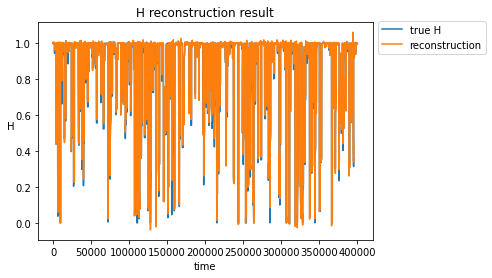

In [17]:
test_recon = AE.predict(test_abundances)
idx_abundances = 0
plt.figure()
plt.plot(test_abundances[:, idx_abundances], label = 'true ' + abundances[idx_abundances])
plt.plot(test_recon[:, idx_abundances], label = 'reconstruction')
plt.legend(bbox_to_anchor=(1., 1.03))
plt.xlabel('time')
plt.ylabel(abundances[idx_abundances], rotation=0)
plt.title(abundances[idx_abundances] + ' reconstruction result')

### Prepare encoded features using the encoder of the autoencoder

In [18]:
abundances_encoded = []
for i in tqdm(range(int(len(train_data)/1000))):
    abundances_encoded.append(AE_encoder.predict(np.array(train_abundances[i*1000:(i+1)*1000])))
    
abundances_test_encoded = []
for i in tqdm(range(int(len(test_data)/1000))):
    abundances_test_encoded.append(AE_encoder.predict(np.array(test_abundances[i*1000:(i+1)*1000])))
    
abundances_encoded = np.concatenate(abundances_encoded, axis =0)
abundances_test_encoded = np.concatenate(abundances_test_encoded, axis =0)

100%|██████████| 400/400 [00:41<00:00,  9.56it/s]


In [19]:
ae_scale = Scale_info(abundances_encoded)
abundances_encoded = (abundances_encoded-ae_scale.min)/(ae_scale.max - ae_scale.min)

train_ae = np.concatenate((np.array(train_data[physics_labels]), abundances_encoded), axis = -1)[:-1]
train_ae_target = np.concatenate((np.array(train_data[['gas_temp']]), abundances_encoded), axis = -1)[1:]

test_ae = np.concatenate((np.array(test_data[physics_labels]), abundances_test_encoded), axis = -1)[:-1]
test_ae_target = np.concatenate((np.array(test_data[['gas_temp']]), abundances_test_encoded), axis = -1)[1:]

print(train_ae.shape)
print(train_ae_target.shape)
print(test_ae.shape)
print(test_ae_target.shape)

(1999999, 16)
(1999999, 9)
(399999, 16)
(399999, 9)


### Train a regression model from encoded featrues and gas temperature

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
model_ae = Sequential()
model_ae.add(Input(shape=(train_ae.shape[1],)))

for layer in [256, 256]:
    model_ae.add(Dense(layer, activation="relu"))

model_ae.add(Dense(1+encoding_dim,activation='sigmoid'))        

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_ae.compile(loss="mse", optimizer=opt)

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_ae.fit(train_ae, train_ae_target, epochs=5, batch_size=128, 
                             validation_data = (test_ae, test_ae_target) ,callbacks=[stopper])
```
    
</p>
</details>

In [20]:
model_ae = Sequential()
model_ae.add(Input(shape=(train_ae.shape[1],)))

for layer in [256, 256]:
    model_ae.add(Dense(layer, activation="relu"))

model_ae.add(Dense(1+encoding_dim,activation='sigmoid'))        

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_ae.compile(loss="mse", optimizer=opt)

stopper=EarlyStopping(monitor ="val_loss", min_delta=0.0,verbose=1,
                      mode="min",
                      restore_best_weights=True,patience=2)
history_all = model_ae.fit(train_ae, train_ae_target, epochs=5, batch_size=128, 
                             validation_data = (test_ae, test_ae_target) ,callbacks=[stopper])

Epoch 1/5
15625/15625 [==============================] - 73s 5ms/step - loss: 6.2647e-04 - val_loss: 1.4921
Epoch 2/5
15625/15625 [==============================] - 72s 5ms/step - loss: 1.0874e-04 - val_loss: 1.4676
Epoch 3/5
15625/15625 [==============================] - 72s 5ms/step - loss: 9.9112e-05 - val_loss: 1.4527
Epoch 4/5
15625/15625 [==============================] - 72s 5ms/step - loss: 9.4357e-05 - val_loss: 1.4453
Epoch 5/5
15625/15625 [==============================] - 78s 5ms/step - loss: 9.1448e-05 - val_loss: 1.4408


### Take a look at some results

Again, using predict_multiple_timesteps function we can predict abundances and gas temperature time series from their initial valeus.

100%|██████████| 999/999 [00:59<00:00, 16.79it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this w

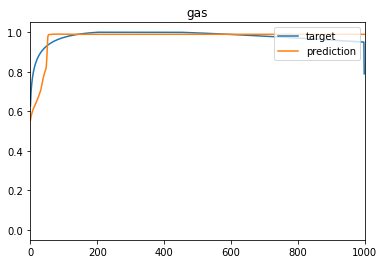

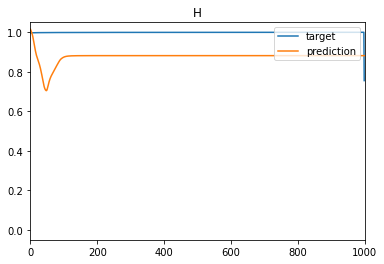

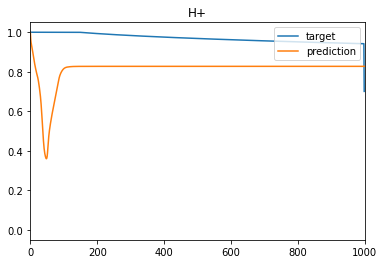

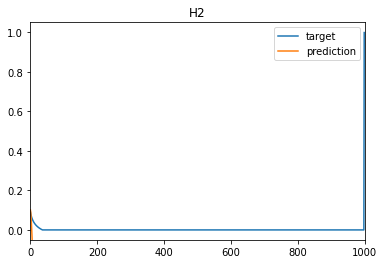

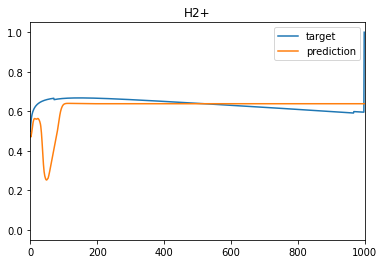

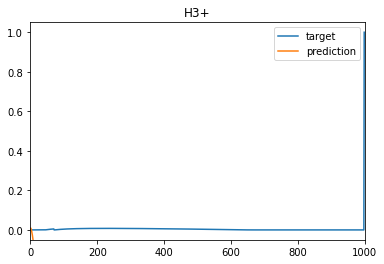

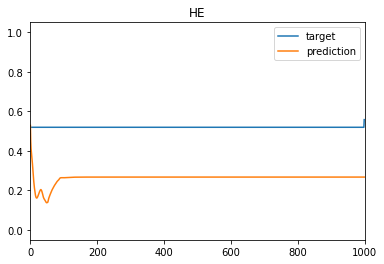

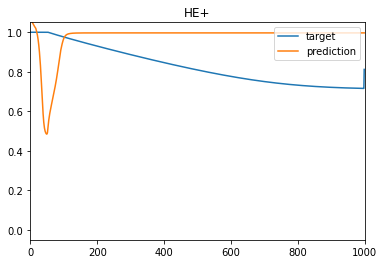

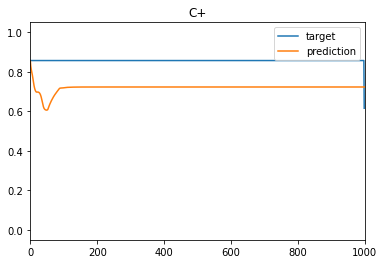

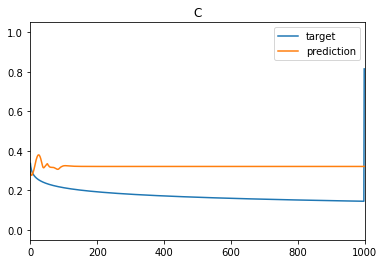

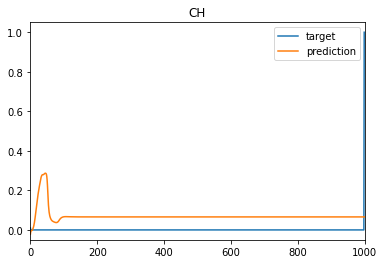

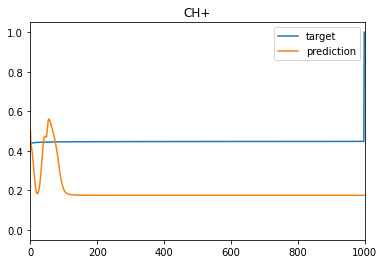

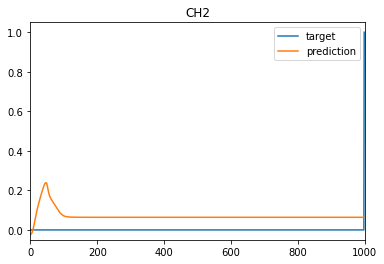

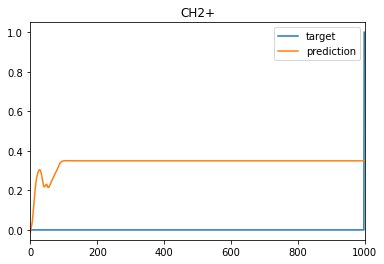

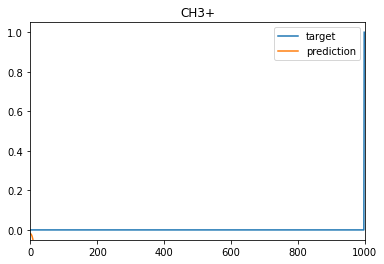

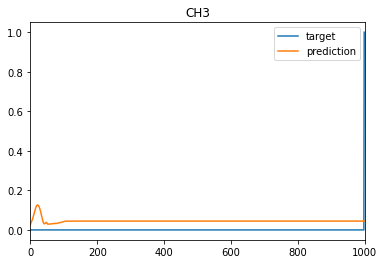

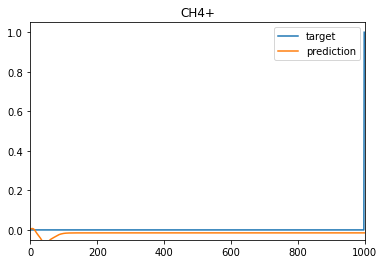

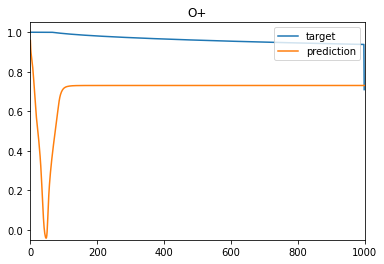

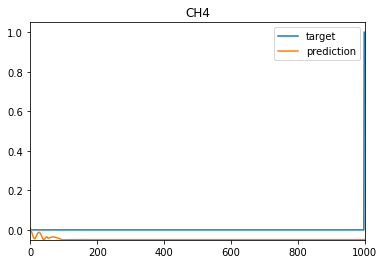

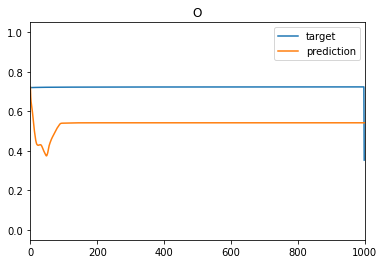

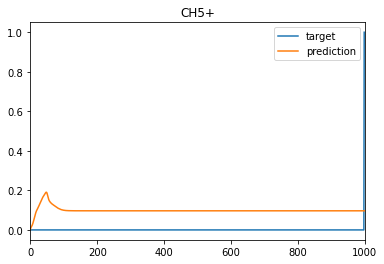

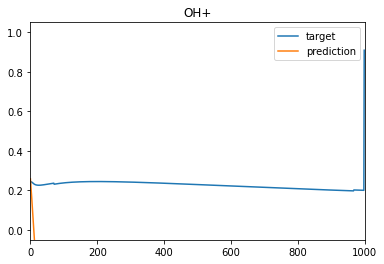

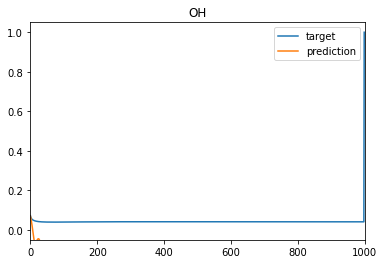

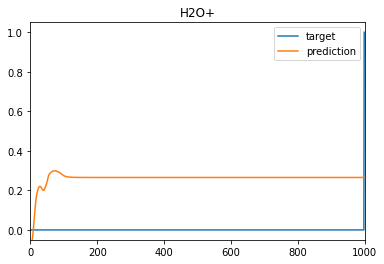

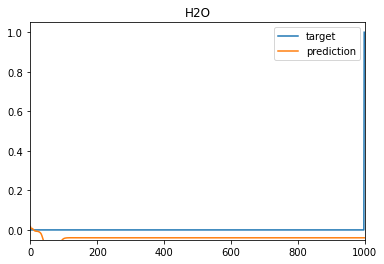

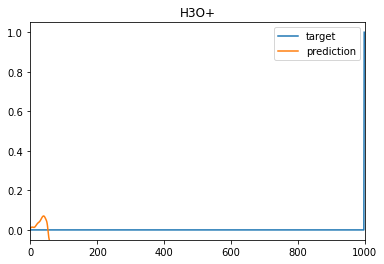

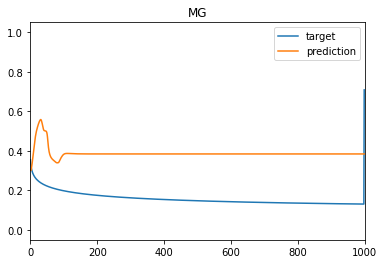

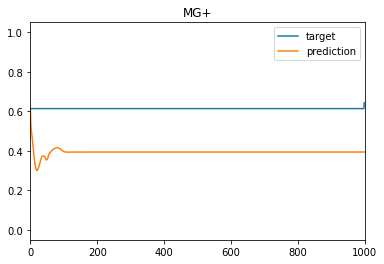

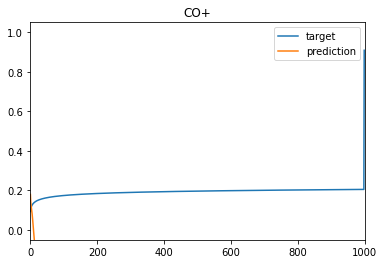

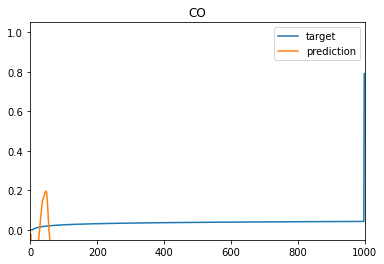

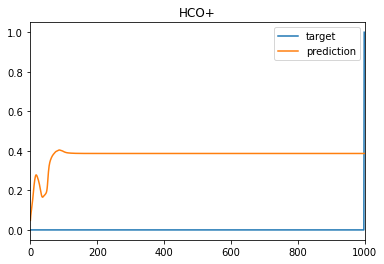

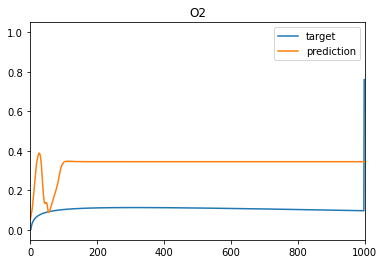

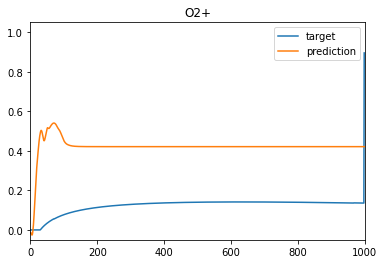

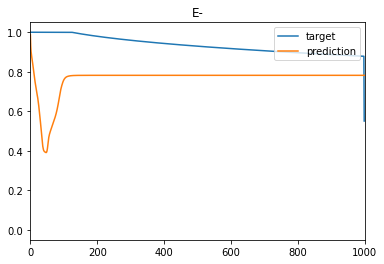

In [23]:
init_idx = 0

init_condition_part = train_ae[init_idx:init_idx+1]
pred_ae = predict_multiple_timesteps(model_ae, init_condition_part, time = 999)

pred_ae = np.stack(pred_ae).reshape(1000, train_ae.shape[1])

pred_ae[:, len(physics_labels):] = (ae_scale.max - ae_scale.min)*pred_ae[:, len(physics_labels):] +ae_scale.min

de_hidden = AE.layers[3](pred_ae[:, len(physics_labels):])
recon_abundances = AE.layers[4](de_hidden)

pred_ae = np.concatenate((pred_ae[:, :len(physics_labels)], recon_abundances), axis = -1)

plt.figure()
plt.plot(train_all_target[init_idx:init_idx+1000, 0], label = 'target')
plt.plot(pred_ae[:, 0],  label = 'prediction')
plt.axis([-1., 1001., -0.05, 1.05])
plt.title('gas')
plt.legend(loc = 1)
for i in range(len(abundances)):
    plt.figure()
    plt.plot(train_all_target[init_idx:init_idx+1000, 1+i], label = 'target')
    plt.plot(pred_ae[:, len(physics_labels)+i], label = 'prediction')
    plt.axis([-1., 1001., -0.05, 1.05])
    plt.title(abundances[i])
    plt.legend(loc = 1)

# 5. Exercise

### Feature extraction using VAE

In this notebook, we used Autoencoders to extracted features and train neural networks with encoded abundances.  
Use a Variational Autoencoders to extract more meaningful features.

- Can you significantly improve the performance?
- Do we need to use $\beta$-vae to balance between reconstruction loss and regulariser?

